In [1]:
import os
import time

import h5py
import numpy as np
import pandas as pd
import tensorflow as tf

import basenji
from basenji import bed
from basenji import dataset
from basenji import seqnn
from basenji import trainer
from basenji import gene as bgene
from basenji import dna_io

import json

import pyranges as pr

import kipoiseq
from kipoiseq import Interval
import pyfaidx

import pysam

import matplotlib.pyplot as plt
import matplotlib.patches as patches


2024-03-21 18:07:31.938294: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-21 18:07:32.011479: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 18:07:40.639270: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Read model parameters

params_file = "params_pred.json"

with open(params_file) as params_open :
    params = json.load(params_open)
    
    params_model = params['model']
    params_train = params['train']


In [3]:
#Read targets (GTEx RNA-seq)

targets_file = '../bench_apa/targets_gtex.txt'

targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index


In [4]:
#Initialize model ensemble

n_folds = 4

SEQUENCE_LENGTH = 524288

models = []

#Loop over model folds
for fold_ix in range(n_folds) :
    
    model_file = "../bench_apa/test_apa/f" + str(fold_ix) + "c0/train/model0_best.h5"

    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file, 0, by_name=False)
    seqnn_model.build_slice(target_index)
    seqnn_model.build_ensemble(True, '0')
    
    models.append(seqnn_model)


2024-03-21 18:08:00.622649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-21 18:08:01.112715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-21 18:08:01.112903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 524288, 4)]  0           []                               
                                                                                                  
 stochastic_reverse_complement   ((None, 524288, 4),  0          ['sequence[0][0]']               
 (StochasticReverseComplement)   ())                                                              
                                                                                                  
 stochastic_shift (StochasticSh  (None, 524288, 4)   0           ['stochastic_reverse_complement[0
 ift)                                                            ][0]']                           
                                                                                            

In [5]:
#Get exon annotation as dataframe
exons_gff_file = '/home/drk/seqnn/analysis/2022/10-19/gencode41_basic_nort_protein_exons.gff'

exons_pr = pr.read_gtf(exons_gff_file)

exons_pr = exons_pr[exons_pr.Feature == 'exonic_part']
exons_pr = exons_pr.drop('Source')
exons_pr = exons_pr.drop('Score')

print("len(exons_pr) = " + str(len(exons_pr)))

#Get basic gene annotation as dataframe
gene_gff_file = './gencode.v41.basic.annotation.gff3'

gene_pr = pr.read_gff3(gene_gff_file)

gene_pr = gene_pr[gene_pr.Feature.isin(['gene', 'exon', 'five_prime_UTR', 'three_prime_UTR'])]

gene_pr = gene_pr.drop('Source')
gene_pr = gene_pr.drop('Score')
gene_pr = gene_pr.drop('Frame')
gene_pr = gene_pr.drop('ID')
gene_pr = gene_pr.drop('hgnc_id')
gene_pr = gene_pr.drop('havana_gene')
gene_pr = gene_pr.drop('Parent')
gene_pr = gene_pr.drop('transcript_support_level')
gene_pr = gene_pr.drop('tag')
gene_pr = gene_pr.drop('havana_transcript')
gene_pr = gene_pr.drop('ont')
gene_pr = gene_pr.drop('protein_id')
gene_pr = gene_pr.drop('ccdsid')
gene_pr = gene_pr.drop('artif_dupl')
gene_pr = gene_pr.drop('level')

print("len(gene_pr) = " + str(len(gene_pr)))

#Get pA annotation as dataframe
polya_gff_file = './gencode.v41.polyAs.gff3'

polya_pr = pr.read_gff3(polya_gff_file)

polya_pr = polya_pr[polya_pr.Feature.isin(['polyA_signal', 'polyA_site'])]

polya_pr = polya_pr.drop('Source')
polya_pr = polya_pr.drop('Score')
polya_pr = polya_pr.drop('Frame')
polya_pr = polya_pr.drop('ID')
polya_pr = polya_pr.drop('gene_type')
polya_pr = polya_pr.drop('gene_name')
polya_pr = polya_pr.drop('transcript_type')
polya_pr = polya_pr.drop('transcript_name')
polya_pr = polya_pr.drop('level')

print("len(polya_pr) = " + str(len(polya_pr)))

#Concatenate annotations
gene_pr = pr.concat([gene_pr, polya_pr])

print("[Final] len(gene_pr) = " + str(len(gene_pr)))


/home/jlinder/anaconda3/envs/basenji_py310/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


len(exons_pr) = 291246


/home/jlinder/anaconda3/envs/basenji_py310/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


len(gene_pr) = 1077833


/home/jlinder/anaconda3/envs/basenji_py310/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


len(polya_pr) = 92482
[Final] len(gene_pr) = 1170315


In [6]:
#Helper functions / classes

from scipy.ndimage import gaussian_filter

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

import gc

#Function to get a one-hot coded sequence pattern
def make_seq_1hot(genome_open, chrm, start, end, seq_len):
    if start < 0:
        seq_dna = 'N'*(-start) + genome_open.fetch(chrm, 0, end)
    else:
        seq_dna = genome_open.fetch(chrm, start, end)
    
    #Extend to full length (pad)
    if len(seq_dna) < seq_len:
        seq_dna += 'N'*(seq_len-len(seq_dna))
    
    seq_1hot = dna_io.dna_1hot(seq_dna)
    
    return seq_1hot

#Function to inject into model definition to get attention scores
def _get_attention_weights(self, inputs, training=False) :
    
    #Initialise the projection layers
    embedding_size = self._value_size * self._num_heads
    seq_len = inputs.shape[1]

    #Compute q, k and v as multi-headed projections of the inputs
    q = self._multihead_output(self._q_layer, inputs)  # [B, H, T, K]
    k = self._multihead_output(self._k_layer, inputs)  # [B, H, T, K]
    v = self._multihead_output(self._v_layer, inputs)  # [B, H, T, V]

    #Scale the query by the square-root of key size
    if self._scaling :
        q *= self._key_size**-0.5

    #[B, H, T', T]
    content_logits = tf.matmul(q + self._r_w_bias, k, transpose_b=True)

    if self._num_position_features == 0 :
        logits = content_logits
    else :
        #Project positions to form relative keys.
        distances = tf.range(-seq_len + 1, seq_len, dtype=tf.float32)[tf.newaxis]
        positional_encodings = basenji.layers.positional_features(
              positions=distances,
              feature_size=self._num_position_features,
              seq_length=seq_len,
              symmetric=self._relative_position_symmetric)
        #[1, 2T-1, Cr]
      
        if training :
            positional_encodings = tf.nn.dropout(
                positional_encodings, rate=self._positional_dropout_rate)

        #[1, H, 2T-1, K]
        r_k = self._multihead_output(self._r_k_layer, positional_encodings)

        #Add shifted relative logits to content logits.
        if self._content_position_bias :
            #[B, H, T', 2T-1]
            relative_logits = tf.matmul(q + self._r_r_bias, r_k, transpose_b=True)
        else :
            #[1, H, 1, 2T-1]
            relative_logits = tf.matmul(self._r_r_bias, r_k, transpose_b=True)
            #[1, H, T', 2T-1]
            relative_logits = tf.broadcast_to(relative_logits, shape=(1, self._num_heads, seq_len, 2*seq_len-1))

        #[B, H, T', T]
        relative_logits = basenji.layers.relative_shift(relative_logits)
        logits = content_logits + relative_logits

    #Apply Softmax across length
    weights = tf.nn.softmax(logits)
    
    return weights

#Function to create a new Keras model, outputting a specific attention layer's scores
def get_attention_model(seqnn_model, layer_ix=0, inital_offset=30, offset=11) :

    #Create new model object
    attention_model = tf.keras.Model(
        seqnn_model.model.layers[1].inputs,
        _get_attention_weights(
            seqnn_model.model.layers[1].layers[inital_offset + offset * layer_ix],
            seqnn_model.model.layers[1].layers[inital_offset + offset * layer_ix - 1].output,
        ),
    )
    
    return attention_model

#Function to predict tracks and attention scores
def predict_tracks_and_attention_scores(models, sequence_one_hot, track_scale=1., track_transform=1., clip_soft=None, n_layers=8, score_rc=True) :
    
    attention_scores = []
    predicted_tracks = []
    
    #Loop over folds
    for fold_ix in range(n_folds) :

        attention_scores_for_fold = []

        yh = models[fold_ix](sequence_one_hot[None, ...])[:, None, ...].astype('float32')
        
        #Undo scale
        yh /= track_scale

        #Undo soft_clip
        if clip_soft is not None :
            yh_unclipped = (yh - clip_soft)**2 + clip_soft
            unclip_mask_h = (yh > clip_soft)

            yh[unclip_mask_h] = yh_unclipped[unclip_mask_h]

        #Undo sqrt
        yh = yh**(1. / track_transform)

        #Aggregate over tracks (average)
        ##yh = np.mean(yh, axis=-1)

        predicted_tracks.append(yh)

        #Loop over layers
        for layer_ix in range(n_layers) :

            #Get attention score model and make predictions
            attention_model = get_attention_model(models[fold_ix], layer_ix=layer_ix)
            att_scores = attention_model.predict(x=[sequence_one_hot[None, ...]], batch_size=1)
            
            #Optionally reverse-complement
            if score_rc :
                att_scores_rc = attention_model.predict(x=[sequence_one_hot[None, ::-1, ::-1]], batch_size=1)
                att_scores = (att_scores + att_scores_rc[..., ::-1, ::-1]) / 2.

            attention_scores_for_fold.append(att_scores[:, None, None, ...])

            attention_model = None
            gc.collect()

        #Concatenate
        attention_scores_for_fold = np.concatenate(attention_scores_for_fold, axis=2)
        attention_scores.append(attention_scores_for_fold)

    #Concatenate
    predicted_tracks = np.concatenate(predicted_tracks, axis=1)
    attention_scores = np.concatenate(attention_scores, axis=1)

    print("predicted_tracks.shape = " + str(predicted_tracks.shape))
    print("attention_scores.shape = " + str(attention_scores.shape))
    
    return predicted_tracks, attention_scores

#Function to predict tracks
def predict_tracks(models, sequence_one_hot, track_scale=1., track_transform=1., clip_soft=None) :
    
    predicted_tracks = []
    
    #Loop over folds
    for fold_ix in range(n_folds) :

        yh = models[fold_ix](sequence_one_hot[None, ...])[:, None, ...].astype('float32')
        
        #Undo scale
        yh /= track_scale

        #Undo soft_clip
        if clip_soft is not None :
            yh_unclipped = (yh - clip_soft)**2 + clip_soft
            unclip_mask_h = (yh > clip_soft)

            yh[unclip_mask_h] = yh_unclipped[unclip_mask_h]

        #Undo sqrt
        yh = yh**(1. / track_transform)

        predicted_tracks.append(yh)

    #Concatenate
    predicted_tracks = np.concatenate(predicted_tracks, axis=1)
    print("predicted_tracks.shape = " + str(predicted_tracks.shape))
    
    return predicted_tracks

#Helper function to get (padded) one-hot and annotated sub-dataframe
def process_sequence(chrom, start, end) :
    
    seq_len = end - start

    #Pad sequence to input window size
    start -= (SEQUENCE_LENGTH - seq_len) // 2
    end += (SEQUENCE_LENGTH - seq_len) // 2

    annotation_df = gene_pr.df.query("Chromosome == '" + chrom + "' and ((End >= " + str(int(start)) + " and End < " + str(int(end)) + ") or (Start >= " + str(int(start)) + " and Start < " + str(int(end)) + "))")

    #Get one-hot
    sequence_one_hot = make_seq_1hot(fasta_open, chrom, start, end, seq_len)
    
    return sequence_one_hot.astype('float32'), annotation_df

#Function for visualizing attention scores and predicted tracks
def plot_attention_score(predicted_tracks, attention_scores, chrom='chr1', start=0, end=1024, track_crop=16, track_pool=1, use_gaussian=False, gaussian_sigma=8, gaussian_truncate=2, plot_start=0, plot_end=1024, save_suffix='', vmin=0.0001, vmax=0.005, highlight_area=False, annotate_features=[], highlight_start=0, highlight_end=1, highlight_start_y=None, highlight_end_y=None, example_ix=0, track_scale_qtl=0.95, track_scale_val=None, track_scale=0.02, track_clip=0.08, fold_index=[0, 1, 2, 3], layer_index=[5, 6], head_index=[0, 1, 2, 3, 4, 5, 6, 7], figsize=(8, 8), fig_dpi=600, save_figs=False) :

    #Average over tracks
    yh = np.mean(predicted_tracks, axis=1)[example_ix, ...]
    
    #Pool track bins
    if track_pool > 1 :
        yh = np.mean(np.reshape(yh, (yh.shape[0] // track_pool, track_pool)), axis=-1)
    
    track_crop_pooled = track_crop // 4
    
    #Calculate track-to-attention ratio
    track_ratio = yh.shape[0] // (4096 - 2 * track_crop_pooled)
    
    if track_scale_val is None :
        track_scale_val = round(np.quantile(yh, q=track_scale_qtl), 4)
        print("track_scale_val = " + str(track_scale_val))
    
    #Zero-pad
    yh = np.concatenate([np.zeros(track_crop_pooled * track_ratio), yh / track_scale_val, np.zeros(track_crop_pooled * track_ratio)], axis=0)
    
    #Average attention map
    att = np.mean(
        np.mean(
            np.mean(
                attention_scores[:, fold_index, ...]
                , axis=1
            )[:, layer_index, ...]
            , axis=1
        )[:, head_index, ...]
        , axis=1
    )[example_ix, ...]
    
    
    #Optionally apply gaussian smoothing to attention map
    if use_gaussian :
        att = gaussian_filter(att, sigma=gaussian_sigma, truncate=gaussian_truncate)

    plot_start_bin = (plot_start - start) // 128
    plot_end_bin = (plot_end - start) // 128

    track_scale = int(track_scale * (plot_end_bin - plot_start_bin))
    track_clip = int(track_clip * (plot_end_bin - plot_start_bin))

    highlight_start_x_bin = (highlight_start - start) // 128
    highlight_end_x_bin = (highlight_end - start) // 128
    
    if highlight_start_y is not None and highlight_end_y is not None :
        highlight_start_y_bin = (highlight_start_y - start) // 128
        highlight_end_y_bin = (highlight_end_y - start) // 128
    else :
        highlight_start_y_bin = (highlight_start - start) // 128
        highlight_end_y_bin = (highlight_end - start) // 128

    att[att < vmin] = 0.

    f = plt.figure(figsize=figsize)

    plt.imshow(att, cmap='hot', vmin=0., vmax=vmax, aspect='equal')

    #Draw highlighted rectangle
    if highlight_area :
        rect = patches.Rectangle(
            (highlight_start_x_bin, highlight_start_y_bin),
            np.minimum(highlight_end_x_bin-highlight_start_x_bin, 4096-highlight_start_x_bin),
            np.minimum(highlight_end_y_bin-highlight_start_y_bin, 4096-highlight_start_y_bin), linewidth=1, edgecolor='magenta', facecolor='none')
        plt.gca().add_patch(rect)

    #Draw annotation features
    for z_order, annotate_dict in enumerate(annotate_features) :

        feature_df = annotation_df.query("Feature == '" + annotate_dict['feature'] + "'" + ((" and " + annotate_dict['filter_query']) if annotate_dict['filter_query'] is not None and annotate_dict['filter_query'] != "" else ""))

        #Loop over features of the given type
        for _, row in feature_df.iterrows() :

            start_f = row['Start']
            end_f = row['End']

            #Plot features of a given length range only
            if end_f - start_f < annotate_dict['min_len'] or end_f - start_f > annotate_dict['max_len'] :
                continue

            start_f_bin = (start_f - start) // 128
            end_f_bin = (end_f - start) // 128

            #Draw gene text annotation
            if annotate_dict['feature'] == 'gene' and annotate_dict['annotate_text'] == True :
                if start_f_bin > plot_start_bin and end_f_bin < plot_end_bin :
                    plt.gca().text(start_f_bin, end_f_bin + 1, ("<- " if row['Strand'] == '-' else "") + row['gene_name'] + (" ->" if row['Strand'] == '+' else ""), ha="left", va="bottom", rotation=0, size=8, color=annotate_dict['color'], fontweight='bold')

            #Draw box, line or dots to highlight feature
            if annotate_dict['plot_type'] == 'box' :
                rect = patches.Rectangle(
                    (start_f_bin, start_f_bin),
                    np.minimum(end_f_bin-start_f_bin, 4096-start_f_bin),
                    np.minimum(end_f_bin-start_f_bin, 4096-start_f_bin), linewidth=2, edgecolor=annotate_dict['color'], facecolor='none')
                plt.gca().add_patch(rect)
            elif annotate_dict['plot_type'] == 'line' :
                plt.plot([start_f_bin, end_f_bin], [start_f_bin, end_f_bin], linewidth=2, color=annotate_dict['color'], zorder=z_order)
            elif annotate_dict['plot_type'] == 'dots' :
                plt.scatter([start_f_bin], [start_f_bin], marker=annotate_dict['marker'], s=annotate_dict['size'], color=annotate_dict['color'], edgecolor='black', linewidth=0.5, zorder=z_order)
                plt.scatter([end_f_bin], [end_f_bin], marker=annotate_dict['marker'], s=annotate_dict['size'], color=annotate_dict['color'], edgecolor='black', linewidth=0.5, zorder=z_order)

    z_order = len(annotate_features)

    #Plot track densities (y-axis)
    plt.gca().fill_between(np.linspace(plot_start_bin, plot_end_bin+track_clip+1, num=yh[plot_start_bin*track_ratio:plot_end_bin*track_ratio].shape[0]+track_clip+1), track_clip + plot_end_bin + 1, y2=plot_end_bin, color='white', zorder=z_order)
    plt.gca().fill_between(np.arange((plot_end_bin - plot_start_bin)*track_ratio)/track_ratio + plot_start_bin, np.clip(track_scale * yh[plot_start_bin*track_ratio:plot_end_bin*track_ratio], 0, track_clip) + plot_end_bin, y2=plot_end_bin, color='deepskyblue', zorder=z_order+1)
    plt.plot(np.arange((plot_end_bin - plot_start_bin)*track_ratio)/track_ratio + plot_start_bin, np.clip(track_scale * yh[plot_start_bin*track_ratio:plot_end_bin*track_ratio], 0, track_clip) + plot_end_bin, linewidth=1, color='black', zorder=z_order+2)

    #Plot densitites (x-axis)
    plt.gca().fill_betweenx(np.linspace(plot_start_bin-track_clip, plot_end_bin, num=yh[plot_start_bin*track_ratio:plot_end_bin*track_ratio].shape[0]+track_clip), track_clip + plot_end_bin + 1, x2=plot_end_bin, color='white', zorder=z_order)
    plt.gca().fill_betweenx(np.arange((plot_end_bin - plot_start_bin)*track_ratio)/track_ratio + plot_start_bin, np.clip(track_scale * yh[plot_start_bin*track_ratio:plot_end_bin*track_ratio], 0, track_clip) + plot_end_bin, x2=plot_end_bin, color='deepskyblue', zorder=z_order+1)
    plt.plot(np.clip(track_scale * yh[plot_start_bin*track_ratio:plot_end_bin*track_ratio], 0, track_clip) + plot_end_bin, np.arange((plot_end_bin - plot_start_bin)*track_ratio)/track_ratio + plot_start_bin, linewidth=1, color='black', zorder=z_order+2)

    #Draw bounding frames
    plt.plot([track_crop_pooled, track_crop_pooled], [4096, 4096 + track_clip], color='red', linestyle='--', linewidth=1, zorder=z_order+3)
    plt.plot([4096 - track_crop_pooled, 4096 - track_crop_pooled], [4096, 4096 + track_clip], color='red', linestyle='--', linewidth=1, zorder=z_order+3)

    plt.plot([4096, 4096 + track_clip], [track_crop_pooled, track_crop_pooled], color='red', linestyle='--', linewidth=1, zorder=z_order+3)
    plt.plot([4096, 4096 + track_clip], [4096 - track_crop_pooled, 4096 - track_crop_pooled], color='red', linestyle='--', linewidth=1, zorder=z_order+3)

    plt.xlim(plot_start_bin, plot_end_bin+track_clip+1)
    plt.ylim(plot_start_bin, plot_end_bin+track_clip+1)

    plt.xticks([], [])
    plt.yticks([], [])

    #Remove borders
    for spine in plt.gca().spines.values():
        spine.set_edgecolor('white')

    plt.gca().set_xlabel("Attended on (" + chrom + ":" + str(plot_start) + "-" + str(plot_end) + ")  --->", fontsize=12, loc='left')
    plt.gca().set_ylabel("Attended by (" + chrom + ":" + str(plot_start) + "-" + str(plot_end) + ")  --->", fontsize=12, loc='bottom')

    plt.tight_layout()

    if save_figs :
        plt.savefig("attention_scores_" + chrom + "_" + str(plot_start) + "-" + str(plot_end) + save_suffix + ".png", dpi=fig_dpi)
        plt.savefig("attention_scores_" + chrom + "_" + str(plot_start) + "-" + str(plot_end) + save_suffix + ".eps")

    plt.show()

#Helper function to plot ACGT letters at a given position
def dna_letter_at(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    fp = FontProperties(family="DejaVu Sans", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange',#'orange', 
                    'A': 'green',#'red', 
                    'C': 'blue',#'blue', 
                    'T': 'red',#'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    return p

#TF function to get average attention gradient
def _attention_input_grad(input_sequence, model, att_start_x, att_end_x, att_start_y, att_end_y, subtract_avg) :

    #Average slice of attention map
    mean_attention = None
    with tf.GradientTape() as tape:
        tape.watch(input_sequence)
        mean_attention = tf.reduce_mean(model(input_sequence)[:, :, att_start_x:att_end_x, att_start_y:att_end_y], axis=(1, 2, 3))

    #Calculate gradient
    input_grad = tape.gradient(mean_attention, input_sequence)
    
    #Optionally mean-subtract
    if subtract_avg :
        input_grad = (input_grad - tf.reduce_mean(input_grad, axis=-1, keepdims=True))
    else :
        input_grad = input_grad

    return input_grad

#Function to compute attention gradient on list of sequences (with rc)
def get_attention_gradient_w_rc(models, sequence_one_hots, att_start_x, att_end_x, att_start_y, att_end_y, subtract_avg=False, fold_index=[0, 1, 2, 3], layer_index=[5, 6], inital_offset=30, offset=11) :
    
    #Get gradients for fwd
    att_grads = get_attention_gradient(models, sequence_one_hots, att_start_x, att_end_x, att_start_y, att_end_y, subtract_avg, fold_index, layer_index, inital_offset, offset)
    
    #Get rev sequences
    sequence_one_hots_rc = [
        sequence_one_hots[example_ix][::-1, ::-1] for example_ix in range(len(sequence_one_hots))
    ]
    
    #Invert attention box
    att_start_x = 4096 - att_start_x - 1
    att_end_x = 4096 - att_end_x - 1
    att_start_y = 4096 - att_start_y - 1
    att_end_y = 4096 - att_end_y - 1
    
    #Get gradients for rev
    att_grads_rc = get_attention_gradient(models, sequence_one_hots_rc, att_end_y, att_start_y, att_end_x, att_start_x, subtract_avg, fold_index, layer_index, inital_offset, offset)
    
    #Average fwd and rev
    att_grads_avg = [
        (att_grads[example_ix] + att_grads_rc[example_ix][::-1, ::-1]) / 2. for example_ix in range(len(sequence_one_hots))
    ]
    
    return att_grads, att_grads_rc, att_grads_avg

#Function to compute attention gradient on list of sequences
def get_attention_gradient(models, sequence_one_hots, att_start_x, att_end_x, att_start_y, att_end_y, subtract_avg=False, fold_index=[0, 1, 2, 3], layer_index=[5, 6], inital_offset=30, offset=11) :
    
    att_grads = np.zeros((len(fold_index), len(layer_index), len(sequence_one_hots), 524288, 4))
    
    #Loop over folds
    for fold_i, fold_ix in enumerate(fold_index) :
        
        seqnn_model = models[fold_ix]
        
        #Loop over layers
        for layer_i, layer_ix in enumerate(layer_index) :

            #Construct attention keras model
            attention_model = tf.keras.Model(
                seqnn_model.model.layers[1].inputs,
                _get_attention_weights(
                    seqnn_model.model.layers[1].layers[inital_offset + offset * layer_ix],
                    seqnn_model.model.layers[1].layers[inital_offset + offset * layer_ix - 1].output,
                ),
            )

            #Define new input tensor
            input_sequence = tf.keras.layers.Input(shape=(524288, 4), name='sequence')

            #Define lambda layer around attention gradient function
            input_grad = tf.keras.layers.Lambda(lambda x: _attention_input_grad(x, attention_model, att_start_x, att_end_x, att_start_y, att_end_y, subtract_avg), name='inp_grad')(input_sequence)

            #Create a new keras model that returns the attention gradient
            grad_model = tf.keras.models.Model(input_sequence, input_grad)
            
            #Calculate gradient on CPU
            with tf.device('/cpu:0') :
                for example_ix in range(len(sequence_one_hots)) :
                    att_grads[fold_i, layer_i, example_ix, ...] = sequence_one_hots[example_ix] * grad_model.predict(x=[sequence_one_hots[example_ix][None, ...]], batch_size=1, verbose=True)[0, ...]
            
            #Run garbage collection before next layer/fold
            attention_model = None
            gc.collect()
    
    #Average and input-gate
    att_grads = np.mean(att_grads, axis=(0, 1))
    att_grads = [
        np.sum(att_grads[example_ix, ...], axis=-1, keepdims=True) * sequence_one_hots[example_ix] for example_ix in range(len(sequence_one_hots))
    ]
    
    return att_grads

#TF function to get gradient of predictions for a subset of positions and tracks (averaged across tracks)
def _prediction_input_grad(input_sequence, model, prox_bin_start, prox_bin_end, dist_bin_start, dist_bin_end, track_index, track_scale, track_transform, clip_soft, use_mean, use_ratio, use_logodds, subtract_avg, prox_bin_index, dist_bin_index) :

    mean_dist_prox_ratio = None
    with tf.GradientTape() as tape:
        tape.watch(input_sequence)
        
        #Predict and gather selected output tracks
        preds = tf.gather(model(input_sequence, training=False), tf.tile(tf.constant(np.array(track_index))[None, :], (tf.shape(input_sequence)[0], 1)), axis=2, batch_dims=1)
        
        #Undo scale
        preds = preds / track_scale

        #Undo soft_clip
        if clip_soft is not None :
            preds = tf.where(preds > clip_soft, (preds - clip_soft)**2 + clip_soft, preds)

        #Undo sqrt
        preds = preds**(1. / track_transform)
      
        #Aggregate over tracks (average)
        pred = tf.reduce_mean(preds, axis=2)
        
        #Aggregate over positions and optionally compute ratios
        if not use_mean :
            #Get sum of distal coverage
            if dist_bin_index is None :
                mean_dist = tf.reduce_sum(pred[:, dist_bin_start:dist_bin_end], axis=1)
            else :
                mean_dist = tf.reduce_sum(tf.gather(pred, dist_bin_index, axis=1), axis=1)
            
            #Get sum of proximal coverage
            if prox_bin_index is None :
                mean_prox = tf.reduce_sum(pred[:, prox_bin_start:prox_bin_end], axis=1)
            else :
                mean_prox = tf.reduce_sum(tf.gather(pred, prox_bin_index, axis=1), axis=1)
        else :
            #Get mean distal coverage
            if dist_bin_index is None :
                mean_dist = tf.reduce_mean(pred[:, dist_bin_start:dist_bin_end], axis=1)
            else :
                mean_dist = tf.reduce_mean(tf.gather(pred, dist_bin_index, axis=1), axis=1)
            
            #Get mean proximal coverage
            if prox_bin_index is None :
                mean_prox = tf.reduce_mean(pred[:, prox_bin_start:prox_bin_end], axis=1)
            else :
                mean_prox = tf.reduce_mean(tf.gather(pred, prox_bin_index, axis=1), axis=1)
        if not use_ratio :
            #Get log-sum of coverage
            mean_dist_prox_ratio = tf.math.log(mean_dist + 1e-6)
        else :
            #Get ratio (or log odds) of distal and proximal coverage samples
            if not use_logodds :
                mean_dist_prox_ratio = tf.math.log(mean_dist / mean_prox + 1e-6)
            else :
                mean_dist_prox_ratio = tf.math.log((mean_dist / mean_prox) / (1. - (mean_dist / mean_prox)) + 1e-6)

    #Calculate gradient and optionally mean-subtract
    input_grad = tape.gradient(mean_dist_prox_ratio, input_sequence)
    if subtract_avg :
        input_grad = (input_grad - tf.reduce_mean(input_grad, axis=-1, keepdims=True))
    else :
        input_grad = input_grad

    return input_grad

#Function to compute prediction gradients for list of sequences (with rc)
def get_prediction_gradient_w_rc(models, sequence_one_hots, prox_bin_start, prox_bin_end, dist_bin_start, dist_bin_end, track_index, track_scale, track_transform, clip_soft=None, prox_bin_index=None, dist_bin_index=None, use_mean=False, use_ratio=True, use_logodds=False, subtract_avg=False, fold_index=[0, 1, 2, 3]) :
    
    #Get gradients for fwd
    pred_grads = get_prediction_gradient(models, sequence_one_hots, prox_bin_start, prox_bin_end, dist_bin_start, dist_bin_end, track_index, track_scale, track_transform, clip_soft, prox_bin_index, dist_bin_index, use_mean, use_ratio, use_logodds, subtract_avg, fold_index)
    
    #Get sequences for rev
    sequence_one_hots_rc = [
        sequence_one_hots[example_ix][::-1, ::-1] for example_ix in range(len(sequence_one_hots))
    ]
    
    #Invert start/end of distal and proximal bins
    prox_bin_start_rc = models[0].target_lengths[0] - prox_bin_start - 1
    prox_bin_end_rc = models[0].target_lengths[0] - prox_bin_end - 1
    
    dist_bin_start_rc = models[0].target_lengths[0] - dist_bin_start - 1
    dist_bin_end_rc = models[0].target_lengths[0] - dist_bin_end - 1
    
    #Invert bin index vectors
    prox_bin_index_rc = None
    if prox_bin_index is not None :
        prox_bin_index_rc = [models[0].target_lengths[0] - prox_bin - 1 for prox_bin in prox_bin_index]
    
    dist_bin_index_rc = None
    if dist_bin_index is not None :
        dist_bin_index_rc = [models[0].target_lengths[0] - dist_bin - 1 for dist_bin in dist_bin_index]
    
    #Get gradients for rev
    pred_grads_rc = get_prediction_gradient(models, sequence_one_hots_rc, prox_bin_end_rc, prox_bin_start_rc, dist_bin_end_rc, dist_bin_start_rc, track_index, track_scale, track_transform, clip_soft, prox_bin_index_rc, dist_bin_index_rc, use_mean, use_ratio, use_logodds, subtract_avg, fold_index)
    
    pred_grads_avg = [
        (pred_grads[example_ix] + pred_grads_rc[example_ix][::-1, ::-1]) / 2. for example_ix in range(len(sequence_one_hots))
    ]
    
    return pred_grads, pred_grads_rc, pred_grads_avg

#Function to compute prediction gradients for list of sequences
def get_prediction_gradient(models, sequence_one_hots, prox_bin_start, prox_bin_end, dist_bin_start, dist_bin_end, track_index, track_scale, track_transform, clip_soft=None, prox_bin_index=None, dist_bin_index=None, use_mean=False, use_ratio=True, use_logodds=False, subtract_avg=False, fold_index=[0, 1, 2, 3]) :
    
    pred_grads = np.zeros((len(sequence_one_hots), len(fold_index), 524288, 4))
    
    #Loop over folds
    for fold_i, fold_ix in enumerate(fold_index) :
        
        prediction_model = models[fold_ix].model.layers[1]
        
        #Create new input tensor
        input_sequence = tf.keras.layers.Input(shape=(524288, 4), name='sequence')

        #Wrap prediction gradient TF function in a lambda layer
        input_grad = tf.keras.layers.Lambda(lambda x: _prediction_input_grad(x, prediction_model, prox_bin_start, prox_bin_end, dist_bin_start, dist_bin_end, track_index, track_scale, track_transform, clip_soft, use_mean, use_ratio, use_logodds, subtract_avg, prox_bin_index, dist_bin_index), name='inp_grad')(input_sequence)

        #Create new keras model that returns the gradient of predictions
        grad_model = tf.keras.models.Model(input_sequence, input_grad)
        
        #Compute gradient on CPU
        with tf.device('/cpu:0') :
            for example_ix in range(len(sequence_one_hots)) :
                pred_grads[example_ix, fold_i, ...] = sequence_one_hots[example_ix] * grad_model.predict(x=[sequence_one_hots[example_ix][None, ...]], batch_size=1, verbose=True)[0, ...]
        
        #Run garbage collection before next fold
        prediction_model = None
        gc.collect()
    
    #Average and mean-subtract
    pred_grads = np.mean(pred_grads, axis=1)
    pred_grads = [
        np.sum(pred_grads[example_ix, ...], axis=-1, keepdims=True) * sequence_one_hots[example_ix] for example_ix in range(len(sequence_one_hots))
    ]
    
    return pred_grads

#Function to calculate prediction statistic for a subset of positions
def _prediction_ism_score(pred, prox_bin_start, prox_bin_end, dist_bin_start, dist_bin_end, use_mean, use_ratio, use_logodds, prox_bin_index, dist_bin_index) :

    #Aggregate over positions and optionally compute ratios
    if not use_mean :
        #Get sum of distal coverage
        if dist_bin_index is None :
            mean_dist = np.sum(pred[:, dist_bin_start:dist_bin_end], axis=1)
        else :
            mean_dist = np.sum(pred[:, dist_bin_index], axis=1)
        
        #Get mean proximal coverage
        if prox_bin_index is None :
            mean_prox = np.sum(pred[:, prox_bin_start:prox_bin_end], axis=1)
        else :
            mean_prox = np.sum(pred[:, prox_bin_index], axis=1)
    else:
        #Get sum of distal coverage
        if dist_bin_index is None :
            mean_dist = np.mean(pred[:, dist_bin_start:dist_bin_end], axis=1)
        else :
            mean_dist = np.mean(pred[:, dist_bin_index], axis=1)
        
        #Get mean proximal coverage
        if prox_bin_index is None :
            mean_prox = np.mean(pred[:, prox_bin_start:prox_bin_end], axis=1)
        else :
            mean_prox = np.mean(pred[:, prox_bin_index], axis=1)
    
    if not use_ratio :
        #Get log-sum of coverage
        mean_dist_prox_ratio = np.log(mean_dist + 1e-6)
    else :
        #Get ratio (or log odds) of distal and proximal coverage samples
        if not use_logodds :
            mean_dist_prox_ratio = np.log(mean_dist / mean_prox + 1e-6)
        else :
            mean_dist_prox_ratio = np.log((mean_dist / mean_prox) / (1. - (mean_dist / mean_prox)) + 1e-6)

    return mean_dist_prox_ratio

#Function to compute ISM scores over a range of positions, for a list of sequences
def get_ism(models, sequence_one_hots, ism_start, ism_end, prox_bin_start, prox_bin_end, dist_bin_start, dist_bin_end, track_index, track_scale, track_transform, clip_soft, prox_bin_index=None, dist_bin_index=None, use_mean=False, use_ratio=True, use_logodds=False) :
    
    pred_ism = np.zeros((len(sequence_one_hots), len(models), 524288, 4))
    
    bases = [0, 1, 2, 3]
    
    #Loop over sequences
    for example_ix in range(len(sequence_one_hots)) :
        
        print("example_ix = " + str(example_ix))
        
        sequence_one_hot_wt = sequence_one_hots[example_ix]
        
        #Get pred
        y_wt = predict_tracks(models, sequence_one_hot_wt)[0, ...][..., track_index].astype('float32')
        
        #Undo scale
        y_wt /= track_scale

        #Undo soft_clip
        if clip_soft is not None :
            y_wt_unclipped = (y_wt - clip_soft)**2 + clip_soft
            unclip_mask_wt = (y_wt > clip_soft)

            y_wt[unclip_mask_wt] = y_wt_unclipped[unclip_mask_wt]

        #Undo sqrt
        y_wt = y_wt**(1. / track_transform)
        
        #Aggregate over tracks (average)
        y_wt = np.mean(y_wt, axis=-1)
        
        #Compute scalar statistics for wt sequence
        score_wt = _prediction_ism_score(y_wt, prox_bin_start, prox_bin_end, dist_bin_start, dist_bin_end, use_mean, use_ratio, use_logodds, prox_bin_index, dist_bin_index)
        
        #Loop over positions in range
        for j in range(ism_start, ism_end) :
            for b in bases :
                #Mutate sequence
                if sequence_one_hot_wt[j, b] != 1. : 
                    sequence_one_hot_mut = np.copy(sequence_one_hot_wt)
                    sequence_one_hot_mut[j, :] = 0.
                    sequence_one_hot_mut[j, b] = 1.
                    
                    #Get pred
                    y_mut = predict_tracks(models, sequence_one_hot_mut)[0, ...][..., track_index].astype('float32')

                    #Undo scale
                    y_mut /= track_scale

                    #Undo soft_clip
                    if clip_soft is not None :
                        y_mut_unclipped = (y_mut - clip_soft)**2 + clip_soft
                        unclip_mask_mut = (y_mut > clip_soft)

                        y_mut[unclip_mask_mut] = y_mut_unclipped[unclip_mask_mut]

                    #Undo sqrt
                    y_mut = y_mut**(1. / track_transform)

                    #Aggregate over tracks (average)
                    y_mut = np.mean(y_mut, axis=-1)
                    
                    #Compute scalar statistic for mutated sequence
                    score_mut = _prediction_ism_score(y_mut, prox_bin_start, prox_bin_end, dist_bin_start, dist_bin_end, use_mean, use_ratio, use_logodds, prox_bin_index, dist_bin_index)
                    
                    pred_ism[example_ix, :, j, b] = score_wt - score_mut
        
        #Average across nucleotides
        pred_ism[example_ix, ...] = np.tile(np.mean(pred_ism[example_ix, ...], axis=-1)[..., None], (1, 1, 4)) * sequence_one_hots[example_ix][None, ...]

    #Average across folds
    pred_ism = np.mean(pred_ism, axis=1)
    pred_ism = [pred_ism[example_ix, ...] for example_ix in range(len(sequence_one_hots))]
    
    return pred_ism

#Function to compute ISM shuffle scores over a range of positions, for a list of sequences
def get_ism_shuffle(models, sequence_one_hots, ism_start, ism_end, prox_bin_start, prox_bin_end, dist_bin_start, dist_bin_end, track_index, track_scale, track_transform, clip_soft, prox_bin_index=None, dist_bin_index=None, window_size=5, n_samples=8, mononuc_shuffle=False, dinuc_shuffle=False, use_mean=False, use_ratio=True, use_logodds=False) :
    
    pred_shuffle = np.zeros((len(sequence_one_hots), len(models), 524288, n_samples))
    pred_ism = np.zeros((len(sequence_one_hots), len(models), 524288, 4))
    
    bases = [0, 1, 2, 3]
    
    #Loop over sequences
    for example_ix in range(len(sequence_one_hots)) :
        
        print("example_ix = " + str(example_ix))
        
        sequence_one_hot_wt = sequence_one_hots[example_ix]
    
        #Get pred
        y_wt = predict_tracks(models, sequence_one_hot_wt)[0, ...][..., track_index].astype('float32')
        
        #Undo scale
        y_wt /= track_scale

        #Undo soft_clip
        if clip_soft is not None :
            y_wt_unclipped = (y_wt - clip_soft)**2 + clip_soft
            unclip_mask_wt = (y_wt > clip_soft)

            y_wt[unclip_mask_wt] = y_wt_unclipped[unclip_mask_wt]

        #Undo sqrt
        y_wt = y_wt**(1. / track_transform)
        
        #Aggregate over tracks (average)
        y_wt = np.mean(y_wt, axis=-1)
        
        #Compute scalar statistics for wt sequence
        score_wt = _prediction_ism_score(y_wt, prox_bin_start, prox_bin_end, dist_bin_start, dist_bin_end, use_mean, use_ratio, use_logodds, prox_bin_index, dist_bin_index)
        
        #Loop over ISM position range
        for j in range(ism_start, ism_end) :
            
            j_start = j - window_size // 2
            j_end = j + window_size // 2 + 1
            
            pos_index = np.arange(j_end-j_start)+j_start
            
            #Loop over samples at position j
            for sample_ix in range(n_samples) :
                sequence_one_hot_mut = np.copy(sequence_one_hot_wt)
                sequence_one_hot_mut[j_start:j_end, :] = 0.
                
                #Randomly mutate
                if not mononuc_shuffle and not dinuc_shuffle :
                    nt_index = np.random.choice(bases, size=(j_end-j_start,)).tolist()
                    sequence_one_hot_mut[pos_index, nt_index] = 1.
                elif mononuc_shuffle :
                    #Shuffle nucleotides
                    shuffled_pos_index = np.copy(pos_index)
                    np.random.shuffle(shuffled_pos_index)
                    
                    sequence_one_hot_mut[shuffled_pos_index, :] = sequence_one_hot_wt[pos_index, :]
                else : #Dinucleotide-shuffle
                    if sample_ix % 2 == 0 :
                        shuffled_pos_index = [
                            [pos_index[pos_j], pos_index[pos_j+1]] if pos_j+1 < pos_index.shape[0] else [pos_index[pos_j]]
                            for pos_j in range(0, pos_index.shape[0], 2)
                        ]
                    else : #Offset sequence by 1 to get other set of dinucleotides
                        pos_index_rev = np.copy(pos_index)[::-1]
                        shuffled_pos_index = [
                            [pos_index_rev[pos_j], pos_index_rev[pos_j+1]] if pos_j+1 < pos_index_rev.shape[0] else [pos_index_rev[pos_j]]
                            for pos_j in range(0, pos_index_rev.shape[0], 2)
                        ]
                    
                    shuffled_shuffle_index = np.arange(len(shuffled_pos_index), dtype='int32')
                    np.random.shuffle(shuffled_shuffle_index)
                    
                    #Shuffle position indices
                    shuffled_pos_index_new = []
                    for pos_tuple_i in range(len(shuffled_pos_index)) :
                        shuffled_pos_index_new.extend(shuffled_pos_index[shuffled_shuffle_index[pos_tuple_i]])
                    
                    #Apply shuffling
                    shuffled_pos_index = np.array(shuffled_pos_index_new, dtype='int32')
                    sequence_one_hot_mut[shuffled_pos_index, :] = sequence_one_hot_wt[pos_index, :]

                #Get pred
                y_mut = predict_tracks(models, sequence_one_hot_mut)[0, ...][..., track_index].astype('float32')

                #Undo scale
                y_mut /= track_scale

                #Undo soft_clip
                if clip_soft is not None :
                    y_mut_unclipped = (y_mut - clip_soft)**2 + clip_soft
                    unclip_mask_mut = (y_mut > clip_soft)

                    y_mut[unclip_mask_mut] = y_mut_unclipped[unclip_mask_mut]

                #Undo sqrt
                y_mut = y_mut**(1. / track_transform)

                #Aggregate over tracks (average)
                y_mut = np.mean(y_mut, axis=-1)
                
                #Compute scalar statistics for mutated sequence
                score_mut = _prediction_ism_score(y_mut, prox_bin_start, prox_bin_end, dist_bin_start, dist_bin_end, use_mean, use_ratio, use_logodds, prox_bin_index, dist_bin_index)

                pred_shuffle[example_ix, :, j, sample_ix] = score_wt - score_mut

        pred_ism[example_ix, ...] = np.tile(np.mean(pred_shuffle[example_ix, ...], axis=-1)[..., None], (1, 1, 4)) * sequence_one_hots[example_ix][None, ...]

    pred_ism = np.mean(pred_ism, axis=1)
    pred_ism = [pred_ism[example_ix, ...] for example_ix in range(len(sequence_one_hots))]
    
    return pred_ism

#Function to plot sequence logo
def plot_seq_scores(importance_scores, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default") :

    importance_scores = importance_scores.T

    fig = plt.figure(figsize=figsize)
    
    ref_seq = ""
    
    #Loop over reference sequence letters
    for j in range(importance_scores.shape[1]) :
        argmax_nt = np.argmax(np.abs(importance_scores[:, j]))
        
        if argmax_nt == 0 :
            ref_seq += "A"
        elif argmax_nt == 1 :
            ref_seq += "C"
        elif argmax_nt == 2 :
            ref_seq += "G"
        elif argmax_nt == 3 :
            ref_seq += "T"

    ax = plt.gca()
    
    #Loop over reference sequence letters and draw
    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        color = None
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax, color=color)
    
    plt.sca(ax)
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    plt.xlim((0, len(ref_seq)))
    
    #plt.axis('off')
    
    if plot_y_ticks :
        plt.yticks(fontsize=12)
    else :
        plt.yticks([], [])
    
    #Set axis limits
    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)
    elif y_min is not None :
        plt.ylim(y_min)
    else :
        plt.ylim(
            np.min(importance_scores) - 0.1 * np.max(np.abs(importance_scores)),
            np.max(importance_scores) + 0.1 * np.max(np.abs(importance_scores))
        )
    
    plt.axhline(y=0., color='black', linestyle='-', linewidth=1)

    #for axis in fig.axes :
    #    axis.get_xaxis().set_visible(False)
    #    axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()

#Plot pair of sequence logos with matched y-axis height
def visualize_input_gradient_pair(att_grad_wt, att_grad_mut, plot_start=0, plot_end=100, save_figs=False, fig_name='') :

    scores_wt = att_grad_wt[plot_start:plot_end, :]
    scores_mut = att_grad_mut[plot_start:plot_end, :]

    #Get logo bounds
    y_min = min(np.min(scores_wt), np.min(scores_mut))
    y_max = max(np.max(scores_wt), np.max(scores_mut))

    y_max_abs = max(np.abs(y_min), np.abs(y_max))

    y_min = y_min - 0.05 * y_max_abs
    y_max = y_max + 0.05 * y_max_abs
    
    print("y_min = " + str(round(y_min, 8)))
    print("y_max = " + str(round(y_max, 8)))

    #Plot wt logo
    print("--- WT ---")
    plot_seq_scores(
        scores_wt, y_min=y_min, y_max=y_max,
        figsize=(8, 1),
        plot_y_ticks=False,
        save_figs=save_figs,
        fig_name=fig_name + '_wt',
    )

    #Plot mut logo
    print("--- Mut ---")
    plot_seq_scores(
        scores_mut, y_min=y_min, y_max=y_max,
        figsize=(8, 1),
        plot_y_ticks=False,
        save_figs=save_figs,
        fig_name=fig_name + '_mut',
    )


In [7]:
#Initialize fasta sequence extractor

fasta_file = 'hg38.fa'

#!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file}
#pyfaidx.Faidx(fasta_file)

fasta_open = pysam.Fastafile(fasta_file)


In [8]:
#Define default annotation settings

annotate_features = [
    {'feature' : 'gene', 'annotate_text' : True, 'filter_query' : "Strand == '+'", 'plot_type' : 'box', 'color' : 'lightgreen', 'marker' : None, 'min_len' : 4096, 'max_len' : 1e9},
    {'feature' : 'gene', 'annotate_text' : True, 'filter_query' : "Strand == '-'", 'plot_type' : 'box', 'color' : 'deepskyblue', 'marker' : None, 'min_len' : 4096, 'max_len' : 1e9},
    
    {'feature' : 'five_prime_UTR', 'annotate_text' : False, 'filter_query' : None, 'plot_type' : 'line', 'color' : 'magenta', 'marker' : None, 'min_len' : 0, 'max_len' : 1e9},
    {'feature' : 'three_prime_UTR', 'annotate_text' : False, 'filter_query' : None, 'plot_type' : 'line', 'color' : 'magenta', 'marker' : None, 'min_len' : 0, 'max_len' : 1e9},
    
    {'feature' : 'exon', 'annotate_text' : False, 'filter_query' : None, 'plot_type' : 'line', 'color' : 'deepskyblue', 'marker' : None, 'min_len' : 0, 'max_len' : 1e9},
    
    {'feature' : 'exon', 'annotate_text' : False, 'filter_query' : None, 'plot_type' : 'dots', 'color' : 'deepskyblue', 'marker' : "*", 'size' : 50, 'min_len' : 0, 'max_len' : 1e9},
    {'feature' : 'polyA_site', 'annotate_text' : False, 'filter_query' : None, 'plot_type' : 'dots', 'color' : 'red', 'marker' : "*", 'size' : 50, 'min_len' : 0, 'max_len' : 1e9},
]


In [13]:
#Predict for example sequence chr1:69993520-70517808

chrom = 'chr1'
start = 69993520
end = 70517808

sequence_one_hot, annotation_df = process_sequence(chrom, start, end)

predicted_tracks, attention_scores = predict_tracks_and_attention_scores(models, sequence_one_hot, score_rc=True)


2023-06-06 10:24:00.864690: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-06-06 10:24:01.196347: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 31ms/step
predicted_tracks.shape = (1, 4, 16352)
attention_scores.shape = (1, 4, 8, 8, 4096, 4096)


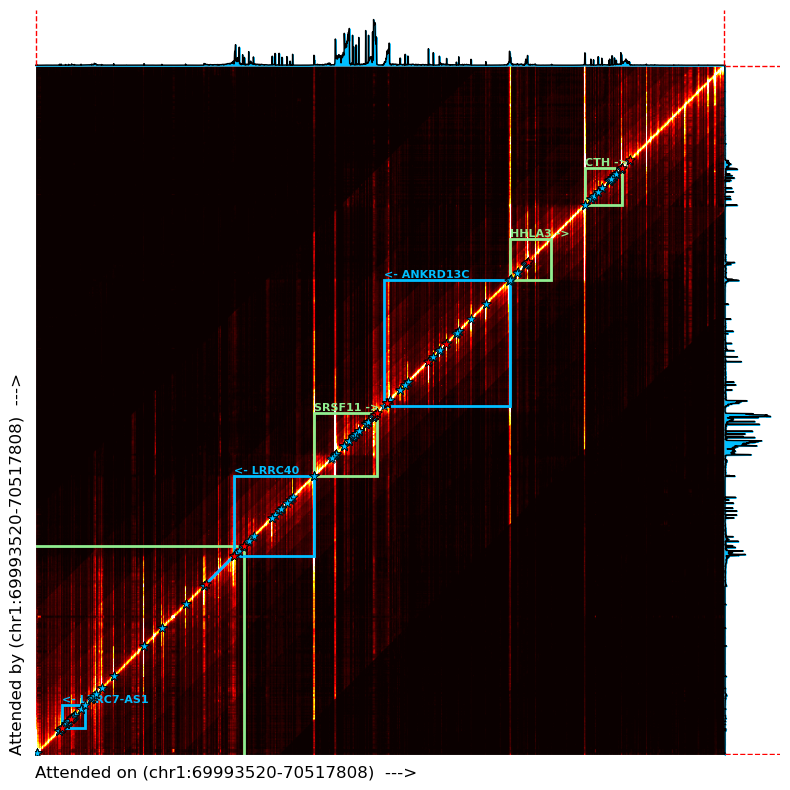

In [17]:
#Viualize scores for sequence chr1:69993520-70517808 (with annotation)

plot_attention_score(
    predicted_tracks,
    attention_scores,
    chrom=chrom,
    start=start,
    end=end,
    track_crop=16,
    track_pool=4,
    plot_start=69993520,
    plot_end=70517808,
    save_suffix='_pooled',
    annotate_features=annotate_features,
    save_figs=True,
    track_scale_qtl=0.98
)


In [9]:
#Predict for example sequence chr1:69967222-70491510 (re-centered on SRSF11), undo transforms

chrom = 'chr1'
start = 69967222
end = 70491510

point_start = 70221710

sequence_one_hot_wt, annotation_df = process_sequence(chrom, start, end)

predicted_tracks_wt, attention_scores_wt = predict_tracks_and_attention_scores(models, sequence_one_hot_wt, track_scale=0.01, track_transform=3./4., clip_soft=384., score_rc=True)

#Also collect original (transformed) predictions
##predicted_tracks_wt_orig, _ = predict_tracks_and_attention_scores(models, sequence_one_hot_wt, score_rc=True)

#Shuffle CRE region while preserving dinucleotide content

#Set start and end positions for local dinuc shuffle
shuffle_start = point_start - start - 3 * 128
shuffle_end = point_start - start - 1 * 128

#Copy wt sequence
sequence_one_hot_mut = np.copy(sequence_one_hot_wt)

#Get vector of positions to shuffle
pos_index = np.arange(shuffle_end-shuffle_start)+shuffle_start

#Clear positions in mutated sequence
sequence_one_hot_mut[shuffle_start:shuffle_end, :] = 0.

#Get list of dinucleotide positions
shuffled_pos_index = [
    [pos_index[pos_j], pos_index[pos_j+1]]
    for pos_j in range(0, pos_index.shape[0], 2)
]

#Get shuffle permutation index

#Set seed
np.random.seed(1234)

shuffled_shuffle_index = np.arange(len(shuffled_pos_index), dtype='int32')
np.random.shuffle(shuffled_shuffle_index)

#Reset seed
np.random.seed()

#Shuffle dinucleotide positions and flatten into nucleotide position index
shuffled_pos_index_new = []
for pos_tuple_i in range(len(shuffled_pos_index)) :
    shuffled_pos_index_new.extend(shuffled_pos_index[shuffled_shuffle_index[pos_tuple_i]])

#Shuffle nucleotides according to position index
shuffled_pos_index = np.array(shuffled_pos_index_new, dtype='int32')
sequence_one_hot_mut[shuffled_pos_index, :] = sequence_one_hot_wt[pos_index, :]

predicted_tracks_mut, attention_scores_mut = predict_tracks_and_attention_scores(models, sequence_one_hot_mut, track_scale=0.01, track_transform=3./4., clip_soft=384., score_rc=True)

#Also collect original (transformed) predictions
##predicted_tracks_mut_orig, _ = predict_tracks_and_attention_scores(models, sequence_one_hot_mut, score_rc=True)


2024-03-21 18:09:15.316068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-03-21 18:09:15.378125: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-21 18:09:17.504378: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 13ms/step
predicted_tracks.shape = (1, 4, 16352, 89)
attention_scores.shape = (1, 4, 8, 8, 4096, 4096)
1/1 [==============================] - 0s 13ms/step
predicted_tracks.shape = (1, 4, 16352, 89)
attention_scores.shape = (1, 4, 8, 8, 4096, 4096)


In [10]:
#Place bounding box over gene attention stripe

bin_size = 128

attention_box_start_x = point_start - 4 * bin_size
attention_box_end_x = point_start + 1 * bin_size

attention_box_start_y = point_start + 50 * bin_size
attention_box_end_y = point_start + 250 * bin_size


In [11]:
#Get brain, lung and blood targets (relative indices)

targets_df['row_index'] = np.arange(len(targets_df), dtype='int32')

print("brain = " + str(targets_df.loc[targets_df['description'] == 'RNA:brain']['row_index'].values.tolist()))
print("lung = " + str(targets_df.loc[targets_df['description'] == 'RNA:lung']['row_index'].values.tolist()))
print("blood = " + str(targets_df.loc[targets_df['description'] == 'RNA:blood']['row_index'].values.tolist()))


brain = [17, 18, 19]
lung = [44, 45, 46]
blood = [9, 10, 11]


In [12]:
#Compute and print predicted coverage fold changes over gene SRSF11 (TSS2)

bin_start = (70221700 - start) // 32 - 16
bin_end = (70255052 - start) // 32 - 16

wt_sum = np.sum(np.mean(predicted_tracks_wt[0, :, bin_start:bin_end, :], axis=0), axis=0)
mut_sum = np.sum(np.mean(predicted_tracks_mut[0, :, bin_start:bin_end, :], axis=0), axis=0)

mut_fc = mut_sum / wt_sum

print(" - average fold change (all tissues) = " + str(round(np.mean(mut_fc), 4)))
print("")

print(" - sorted in decreasing order of coverage loss - ")

target_names = sorted(targets_df['description'].unique().tolist())
target_fcs = []
target_wts = []

# loop over targets
for target_name in target_names :
    
    target_list = targets_df.loc[targets_df['description'] == target_name]['row_index'].values.tolist()
    target_fcs.append(round(np.mean(mut_fc[target_list]), 4))
    target_wts.append(round(np.mean(wt_sum[target_list]), 4))

target_fc = np.array(target_fcs, dtype='float32')
target_wt = np.array(target_wts, dtype='float32')

# loop over targets again (print in sorted order)
sort_index = np.argsort(target_fc)
for i in sort_index :
    
    target_list = targets_df.loc[targets_df['description'] == target_names[i]]['row_index'].values.tolist()
    print(str(target_fc[i]) + " (" + target_names[i] + "; " + str(target_list) + "; " + str(target_wt[i]) + ")")


 - average fold change (all tissues) = 0.3717

 - sorted in decreasing order of coverage loss - 
0.2044 (RNA:brain; [17, 18, 19]; 23741466.0)
0.2059 (RNA:fallopian_tube; [32, 33, 34]; 10718187.0)
0.214 (RNA:pituitary; [58, 59, 60]; 13703256.0)
0.2329 (RNA:thyroid; [81, 82, 83]; 7580525.5)
0.2349 (RNA:lung; [44, 45, 46]; 6158716.0)
0.2464 (RNA:small_intestine; [70, 71, 72]; 18449242.0)
0.2489 (RNA:colon; [26, 27, 28]; 4256230.0)
0.2651 (RNA:nerve; [50, 51]; 11491882.0)
0.2676 (RNA:vagina; [86, 87, 88]; 10322507.0)
0.2722 (RNA:cervix_uteri; [23, 24, 25]; 16101836.0)
0.2753 (RNA:breast; [20, 21, 22]; 12506360.0)
0.2823 (RNA:uterus; [84, 85]; 7800135.0)
0.2987 (RNA:bladder; [6, 7, 8]; 6559934.5)
0.3018 (RNA:ovary; [52, 53, 54]; 20435036.0)
0.315 (RNA:esophagus; [29, 30, 31]; 6776747.5)
0.3186 (RNA:salivary_gland; [64, 65, 66]; 5291556.0)
0.3225 (RNA:spleen; [73, 74, 75]; 27480384.0)
0.3276 (RNA:blood_vessel; [12, 13, 14]; 7014988.0)
0.3451 (RNA:prostate; [61, 62, 63]; 10205536.0)
0.3594 (R

In [14]:
#Visualize attention map and predicted coverage (SRSF11 window, raw transformed tracks)

track_scale_val = 1.4292


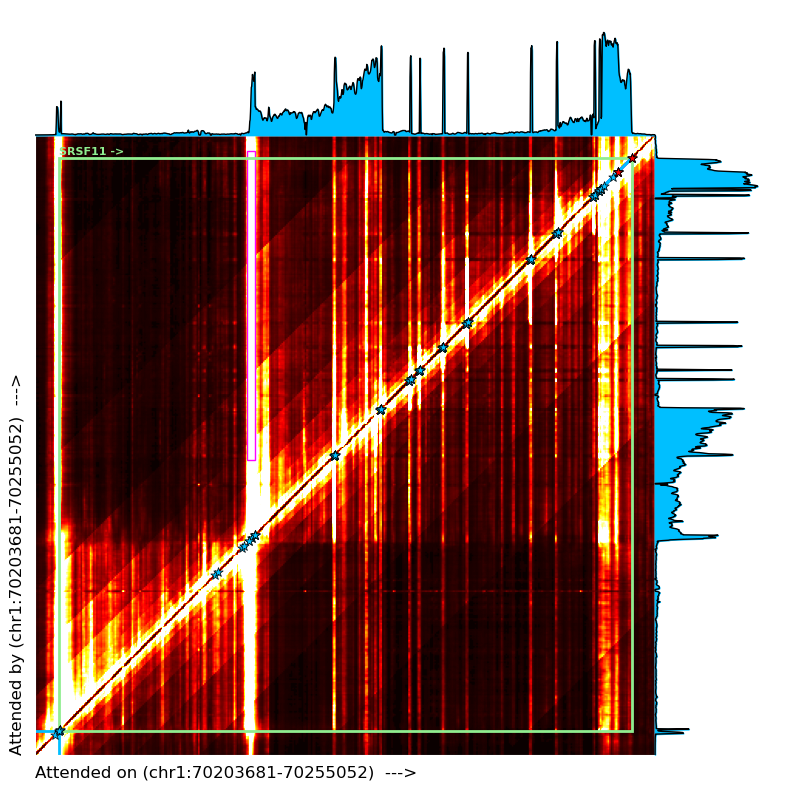

In [82]:
#Viualize scores for sequence chr1:70203681-70255052 (wildtype)

plot_attention_score(
    np.mean(predicted_tracks_wt_orig[..., :], axis=-1),
    attention_scores_wt,
    chrom=chrom,
    start=start,
    end=end,
    plot_start=70203681,
    plot_end=70255052,
    track_crop=16,
    track_pool=1,
    save_suffix='_wt_highlight_tss4',
    annotate_features=annotate_features,
    track_scale=0.05,
    track_clip=0.20,
    track_scale_qtl=0.98,
    highlight_area=True,
    highlight_start=attention_box_start_x,
    highlight_end=attention_box_end_x,
    highlight_start_y=attention_box_start_y,
    highlight_end_y=attention_box_end_y,
    save_figs=True,
)


In [ ]:
#Visualize attention map and predicted coverage (SRSF11 window, clipping and transforms inverted)

track_scale_val = 83437.4047


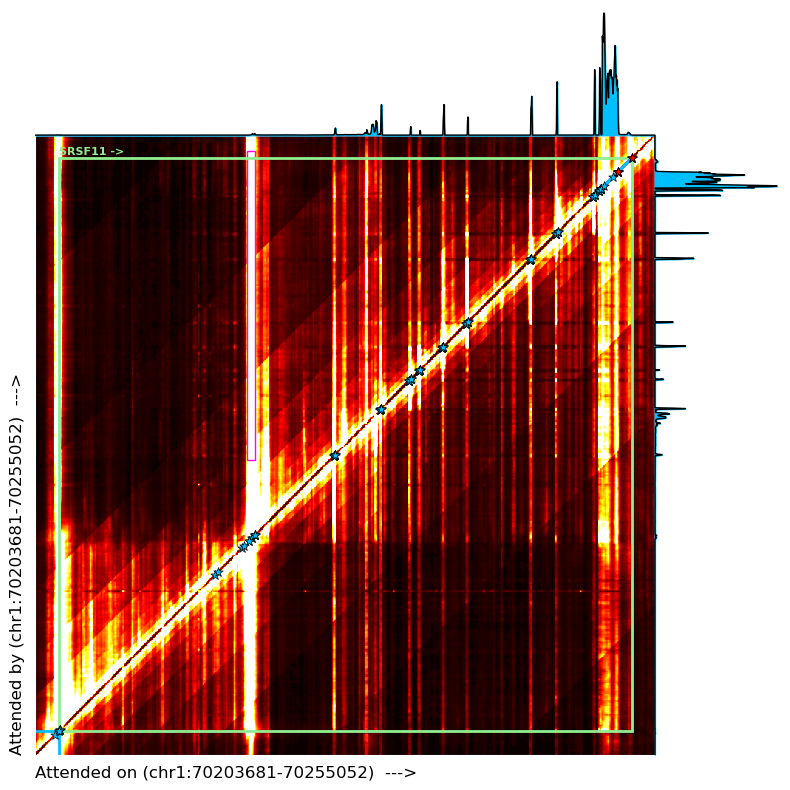

In [94]:
#Viualize scores for sequence chr1:70203681-70255052 (wildtype)

plot_attention_score(
    np.mean(predicted_tracks_wt[..., :], axis=-1),
    attention_scores_wt,
    chrom=chrom,
    start=start,
    end=end,
    plot_start=70203681,
    plot_end=70255052,
    track_crop=16,
    track_pool=1,
    save_suffix='_wt_highlight_tss4_undo_clip',
    annotate_features=annotate_features,
    track_scale=0.05,
    track_clip=0.20,
    track_scale_qtl=0.997,
    highlight_area=True,
    highlight_start=attention_box_start_x,
    highlight_end=attention_box_end_x,
    highlight_start_y=attention_box_start_y,
    highlight_end_y=attention_box_end_y,
    save_figs=True,
)


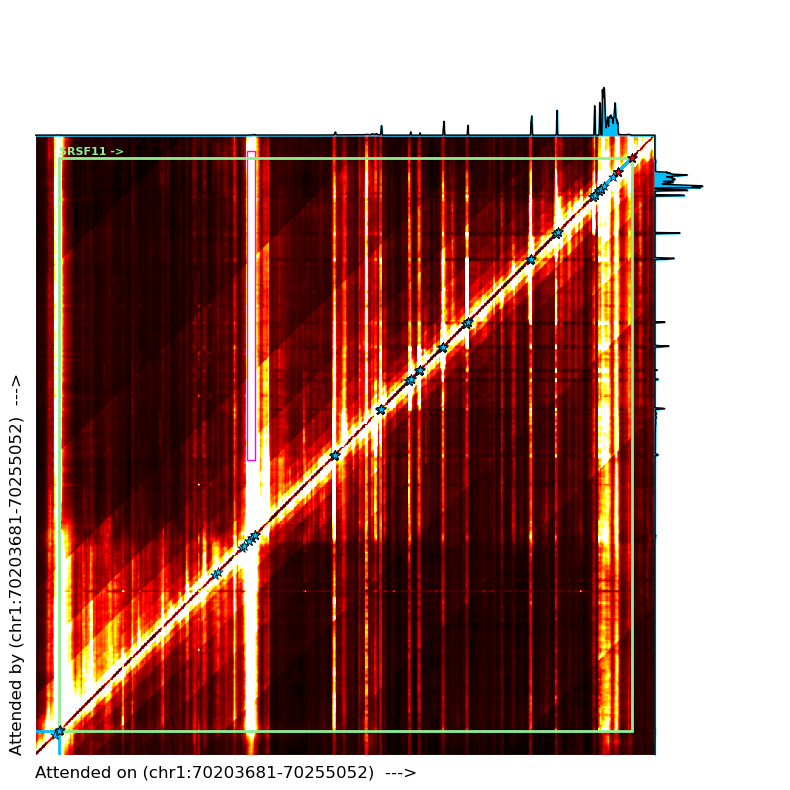

In [95]:
#Viualize scores for sequence chr1:70203681-70255052 (mutated)

plot_attention_score(
    np.mean(predicted_tracks_mut[..., :], axis=-1),
    attention_scores_mut,
    chrom=chrom,
    start=start,
    end=end,
    plot_start=70203681,
    plot_end=70255052,
    track_crop=16,
    track_pool=1,
    save_suffix='_mut_highlight_tss4_undo_clip',
    annotate_features=annotate_features,
    track_scale=0.05,
    track_clip=0.20,
    track_scale_val=83437.4047,#track_scale_qtl=0.997, #Match wt limit above
    highlight_area=True,
    highlight_start=attention_box_start_x,
    highlight_end=attention_box_end_x,
    highlight_start_y=attention_box_start_y,
    highlight_end_y=attention_box_end_y,
    save_figs=True,
)


In [ ]:
#Attention gradient saliency analysis

In [13]:
#Get contribution scores (gradient) for attention stripe

attention_box_start_x_bin = (attention_box_start_x - start) // 128
attention_box_end_x_bin = (attention_box_end_x - start) // 128

attention_box_start_y_bin = (attention_box_start_y - start) // 128
attention_box_end_y_bin = (attention_box_end_y - start) // 128

_, _, [att_grad_wt] = get_attention_gradient_w_rc(
    models,
    [sequence_one_hot_wt],
    attention_box_start_y_bin,
    attention_box_end_y_bin,
    attention_box_start_x_bin,
    attention_box_end_x_bin,
    subtract_avg=True,
    fold_index=[0, 1, 2, 3],
    layer_index=[5, 6]
)


The following Variables were used a Lambda layer's call (inp_grad), but
are not present in its tracked objects:
  <tf.Variable 'conv1d/kernel:0' shape=(15, 4, 512) dtype=float32>
  <tf.Variable 'conv1d/bias:0' shape=(512,) dtype=float32>
  <tf.Variable 'sync_batch_normalization/gamma:0' shape=(512,) dtype=float32>
  <tf.Variable 'sync_batch_normalization/beta:0' shape=(512,) dtype=float32>
  <tf.Variable 'conv1d_1/kernel:0' shape=(5, 512, 608) dtype=float32>
  <tf.Variable 'conv1d_1/bias:0' shape=(608,) dtype=float32>
  <tf.Variable 'sync_batch_normalization_1/gamma:0' shape=(608,) dtype=float32>
  <tf.Variable 'sync_batch_normalization_1/beta:0' shape=(608,) dtype=float32>
  <tf.Variable 'conv1d_2/kernel:0' shape=(5, 608, 736) dtype=float32>
  <tf.Variable 'conv1d_2/bias:0' shape=(736,) dtype=float32>
  <tf.Variable 'sync_batch_normalization_2/gamma:0' shape=(736,) dtype=float32>
  <tf.Variable 'sync_batch_normalization_2/beta:0' shape=(736,) dtype=float32>
  <tf.Variable 'conv1d_3/ke

y_min = -0.00016394
y_max = 0.00023561
--- WT ---


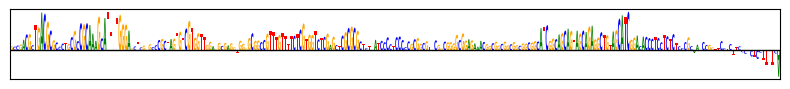

--- Mut ---


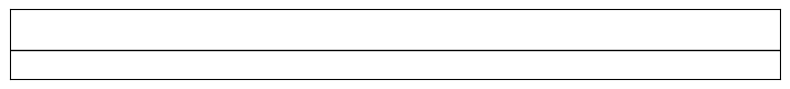

In [15]:
#Visualize contribution scores

visualize_input_gradient_pair(
    att_grad_wt,
    np.zeros(att_grad_wt.shape),
    plot_start=point_start - start - 3 * 128,
    plot_end=point_start - start - 1 * 128,
    save_figs=True,
    fig_name=chrom + '_' + str(start) + '_' + str(end) + '_attention_grad_mut_tss4_5_folds_256bp_wt_only_retry2'
)


In [ ]:
#Coverage track gradient saliency analysis

In [ ]:
#Tissues to compute individual gradient maps for

'''
0.2044 (RNA:brain; [17, 18, 19]; 23753670.0)
0.2348 (RNA:lung; [44, 45, 46]; 6163846.5)
0.7602 (RNA:blood; [9, 10, 11]; 10145517.0)
'''


In [19]:
#Get contribution scores (gradient) for gene coverage; brain

OUTPUT_LENGTH = 16352

dist_bin_start = (70221700 - start - ((SEQUENCE_LENGTH - OUTPUT_LENGTH * 32) // 2)) // 32
dist_bin_end = (70255052 - start - ((SEQUENCE_LENGTH - OUTPUT_LENGTH * 32) // 2)) // 32

_, _, [pred_grad_wt] = get_prediction_gradient_w_rc(
    models,
    [sequence_one_hot_wt],
    0,
    0,
    dist_bin_start,
    dist_bin_end,
    target_index[[17, 18, 19]].tolist(),
    0.01,
    3./4.,
    clip_soft=384.,
    use_mean=False,
    use_ratio=False,
    use_logodds=False,
    subtract_avg=True,
    fold_index=[0, 1, 2, 3],
)


The following Variables were used a Lambda layer's call (inp_grad), but
are not present in its tracked objects:
  <tf.Variable 'conv1d/kernel:0' shape=(15, 4, 512) dtype=float32>
  <tf.Variable 'conv1d/bias:0' shape=(512,) dtype=float32>
  <tf.Variable 'sync_batch_normalization/gamma:0' shape=(512,) dtype=float32>
  <tf.Variable 'sync_batch_normalization/beta:0' shape=(512,) dtype=float32>
  <tf.Variable 'conv1d_1/kernel:0' shape=(5, 512, 608) dtype=float32>
  <tf.Variable 'conv1d_1/bias:0' shape=(608,) dtype=float32>
  <tf.Variable 'sync_batch_normalization_1/gamma:0' shape=(608,) dtype=float32>
  <tf.Variable 'sync_batch_normalization_1/beta:0' shape=(608,) dtype=float32>
  <tf.Variable 'conv1d_2/kernel:0' shape=(5, 608, 736) dtype=float32>
  <tf.Variable 'conv1d_2/bias:0' shape=(736,) dtype=float32>
  <tf.Variable 'sync_batch_normalization_2/gamma:0' shape=(736,) dtype=float32>
  <tf.Variable 'sync_batch_normalization_2/beta:0' shape=(736,) dtype=float32>
  <tf.Variable 'conv1d_3/ke

y_min = -0.06626564
y_max = 0.14411582
--- WT ---


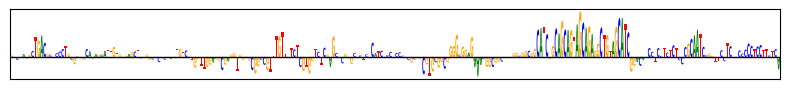

--- Mut ---


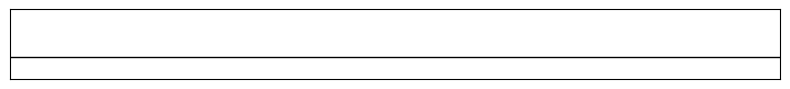

In [21]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_grad_wt,
    np.zeros(pred_grad_wt.shape),
    plot_start=point_start - start - 3 * 128,
    plot_end=point_start - start - 1 * 128,
    save_figs=True,
    fig_name=chrom + '_' + str(start) + '_' + str(end) + '_prediction_grad_mut_tss4_5_folds_256bp_wt_only_brain_retry2'
)


In [22]:
#Get contribution scores (gradient) for gene coverage; lung

OUTPUT_LENGTH = 16352

dist_bin_start = (70221700 - start - ((SEQUENCE_LENGTH - OUTPUT_LENGTH * 32) // 2)) // 32
dist_bin_end = (70255052 - start - ((SEQUENCE_LENGTH - OUTPUT_LENGTH * 32) // 2)) // 32

_, _, [pred_grad_wt] = get_prediction_gradient_w_rc(
    models,
    [sequence_one_hot_wt],
    0,
    0,
    dist_bin_start,
    dist_bin_end,
    target_index[[44, 45, 46]].tolist(),
    0.01,
    3./4.,
    clip_soft=384.,
    use_mean=False,
    use_ratio=False,
    use_logodds=False,
    subtract_avg=True,
    fold_index=[0, 1, 2, 3],
)


The following Variables were used a Lambda layer's call (inp_grad), but
are not present in its tracked objects:
  <tf.Variable 'conv1d/kernel:0' shape=(15, 4, 512) dtype=float32>
  <tf.Variable 'conv1d/bias:0' shape=(512,) dtype=float32>
  <tf.Variable 'sync_batch_normalization/gamma:0' shape=(512,) dtype=float32>
  <tf.Variable 'sync_batch_normalization/beta:0' shape=(512,) dtype=float32>
  <tf.Variable 'conv1d_1/kernel:0' shape=(5, 512, 608) dtype=float32>
  <tf.Variable 'conv1d_1/bias:0' shape=(608,) dtype=float32>
  <tf.Variable 'sync_batch_normalization_1/gamma:0' shape=(608,) dtype=float32>
  <tf.Variable 'sync_batch_normalization_1/beta:0' shape=(608,) dtype=float32>
  <tf.Variable 'conv1d_2/kernel:0' shape=(5, 608, 736) dtype=float32>
  <tf.Variable 'conv1d_2/bias:0' shape=(736,) dtype=float32>
  <tf.Variable 'sync_batch_normalization_2/gamma:0' shape=(736,) dtype=float32>
  <tf.Variable 'sync_batch_normalization_2/beta:0' shape=(736,) dtype=float32>
  <tf.Variable 'conv1d_3/ke

y_min = -0.0775818
y_max = 0.16587896
--- WT ---


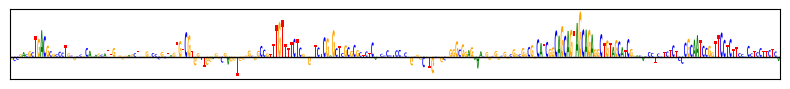

--- Mut ---


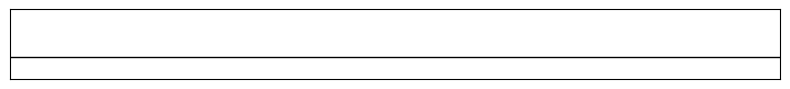

In [24]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_grad_wt,
    np.zeros(pred_grad_wt.shape),
    plot_start=point_start - start - 3 * 128,
    plot_end=point_start - start - 1 * 128,
    save_figs=True,
    fig_name=chrom + '_' + str(start) + '_' + str(end) + '_prediction_grad_mut_tss4_5_folds_256bp_wt_only_lung_retry2'
)


In [25]:
#Get contribution scores (gradient) for gene coverage; blood

OUTPUT_LENGTH = 16352

dist_bin_start = (70221700 - start - ((SEQUENCE_LENGTH - OUTPUT_LENGTH * 32) // 2)) // 32
dist_bin_end = (70255052 - start - ((SEQUENCE_LENGTH - OUTPUT_LENGTH * 32) // 2)) // 32

_, _, [pred_grad_wt] = get_prediction_gradient_w_rc(
    models,
    [sequence_one_hot_wt],
    0,
    0,
    dist_bin_start,
    dist_bin_end,
    target_index[[9, 10, 11]].tolist(),
    0.01,
    3./4.,
    clip_soft=384.,
    use_mean=False,
    use_ratio=False,
    use_logodds=False,
    subtract_avg=True,
    fold_index=[0, 1, 2, 3],
)


The following Variables were used a Lambda layer's call (inp_grad), but
are not present in its tracked objects:
  <tf.Variable 'conv1d/kernel:0' shape=(15, 4, 512) dtype=float32>
  <tf.Variable 'conv1d/bias:0' shape=(512,) dtype=float32>
  <tf.Variable 'sync_batch_normalization/gamma:0' shape=(512,) dtype=float32>
  <tf.Variable 'sync_batch_normalization/beta:0' shape=(512,) dtype=float32>
  <tf.Variable 'conv1d_1/kernel:0' shape=(5, 512, 608) dtype=float32>
  <tf.Variable 'conv1d_1/bias:0' shape=(608,) dtype=float32>
  <tf.Variable 'sync_batch_normalization_1/gamma:0' shape=(608,) dtype=float32>
  <tf.Variable 'sync_batch_normalization_1/beta:0' shape=(608,) dtype=float32>
  <tf.Variable 'conv1d_2/kernel:0' shape=(5, 608, 736) dtype=float32>
  <tf.Variable 'conv1d_2/bias:0' shape=(736,) dtype=float32>
  <tf.Variable 'sync_batch_normalization_2/gamma:0' shape=(736,) dtype=float32>
  <tf.Variable 'sync_batch_normalization_2/beta:0' shape=(736,) dtype=float32>
  <tf.Variable 'conv1d_3/ke

y_min = -0.12564772
y_max = 0.10282833
--- WT ---


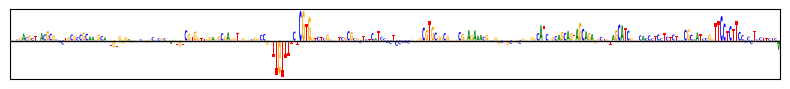

--- Mut ---


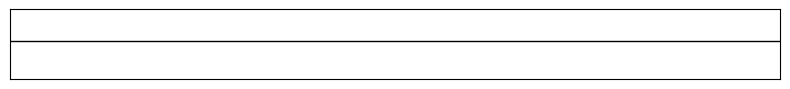

In [27]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_grad_wt,
    np.zeros(pred_grad_wt.shape),
    plot_start=point_start - start - 3 * 128,
    plot_end=point_start - start - 1 * 128,
    save_figs=True,
    fig_name=chrom + '_' + str(start) + '_' + str(end) + '_prediction_grad_mut_tss4_5_folds_256bp_wt_only_blood_retry2'
)


In [ ]:
#Coverage track ISM analysis

In [ ]:
#Tissues to compute individual ISM maps for

'''
0.2044 (RNA:brain; [17, 18, 19]; 23753670.0)
0.2348 (RNA:lung; [44, 45, 46]; 6163846.5)
0.7602 (RNA:blood; [9, 10, 11]; 10145517.0)
'''


In [30]:
#Get contribution scores (ISM) for gene coverage; brain

OUTPUT_LENGTH = 16352

dist_bin_start = (70221700 - start - ((SEQUENCE_LENGTH - OUTPUT_LENGTH * 32) // 2)) // 32
dist_bin_end = (70255052 - start - ((SEQUENCE_LENGTH - OUTPUT_LENGTH * 32) // 2)) // 32

[pred_ism_wt] = get_ism(
    models,
    [sequence_one_hot_wt],
    point_start - start - 3 * 128,
    point_start - start - 1 * 128,
    0,
    1,
    dist_bin_start,
    dist_bin_end,
    [17, 18, 19],
    0.01,
    3./4.,
    384.,
    use_mean=True,
    use_ratio=False,
    use_logodds=False,
)


example_ix = 0
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 

y_min = -0.06731634
y_max = 0.09882997
--- WT ---


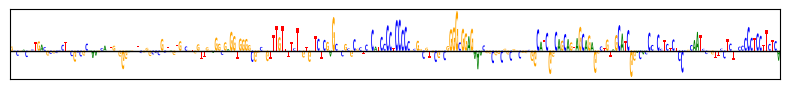

--- Mut ---


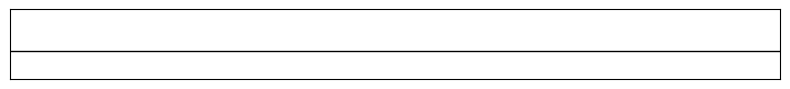

In [31]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_ism_wt,
    np.zeros(pred_ism_wt.shape),
    plot_start=point_start - start - 3 * 128,
    plot_end=point_start - start - 1 * 128,
    save_figs=True,
    fig_name=chrom + '_' + str(start) + '_' + str(end) + '_prediction_ism_mut_tss4_5_folds_256bp_wt_only_brain_retry2'
)


In [32]:
#Get contribution scores (ISM) for gene coverage; lung

OUTPUT_LENGTH = 16352

dist_bin_start = (70221700 - start - ((SEQUENCE_LENGTH - OUTPUT_LENGTH * 32) // 2)) // 32
dist_bin_end = (70255052 - start - ((SEQUENCE_LENGTH - OUTPUT_LENGTH * 32) // 2)) // 32

[pred_ism_wt] = get_ism(
    models,
    [sequence_one_hot_wt],
    point_start - start - 3 * 128,
    point_start - start - 1 * 128,
    0,
    1,
    dist_bin_start,
    dist_bin_end,
    [44, 45, 46],
    0.01,
    3./4.,
    384.,
    use_mean=True,
    use_ratio=False,
    use_logodds=False,
)


example_ix = 0
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 

y_min = -0.10100961
y_max = 0.10680059
--- WT ---


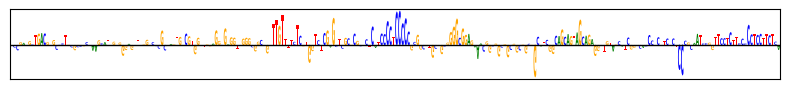

--- Mut ---


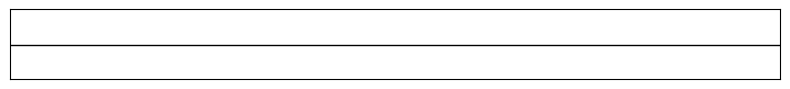

In [33]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_ism_wt,
    np.zeros(pred_ism_wt.shape),
    plot_start=point_start - start - 3 * 128,
    plot_end=point_start - start - 1 * 128,
    save_figs=True,
    fig_name=chrom + '_' + str(start) + '_' + str(end) + '_prediction_ism_mut_tss4_5_folds_256bp_wt_only_lung_retry2'
)


In [34]:
#Get contribution scores (ISM) for gene coverage; blood

OUTPUT_LENGTH = 16352

dist_bin_start = (70221700 - start - ((SEQUENCE_LENGTH - OUTPUT_LENGTH * 32) // 2)) // 32
dist_bin_end = (70255052 - start - ((SEQUENCE_LENGTH - OUTPUT_LENGTH * 32) // 2)) // 32

[pred_ism_wt] = get_ism(
    models,
    [sequence_one_hot_wt],
    point_start - start - 3 * 128,
    point_start - start - 1 * 128,
    0,
    1,
    dist_bin_start,
    dist_bin_end,
    [9, 10, 11],
    0.01,
    3./4.,
    384.,
    use_mean=True,
    use_ratio=False,
    use_logodds=False,
)


example_ix = 0
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 

y_min = -0.07570323
y_max = 0.05456939
--- WT ---


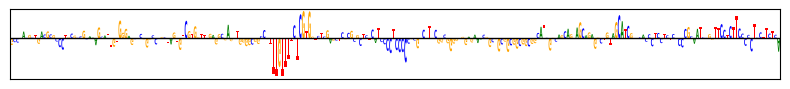

--- Mut ---


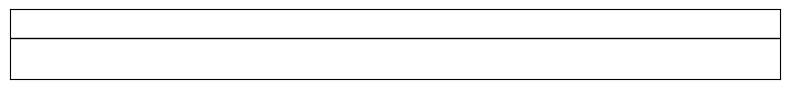

In [35]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_ism_wt,
    np.zeros(pred_ism_wt.shape),
    plot_start=point_start - start - 3 * 128,
    plot_end=point_start - start - 1 * 128,
    save_figs=True,
    fig_name=chrom + '_' + str(start) + '_' + str(end) + '_prediction_ism_mut_tss4_5_folds_256bp_wt_only_blood_retry2'
)


In [ ]:
#Coverage track ISM Shuffle analysis

In [ ]:
#Tissues to compute individual ISM Shuffle maps for

'''
0.2044 (RNA:brain; [17, 18, 19]; 23753670.0)
0.2348 (RNA:lung; [44, 45, 46]; 6163846.5)
0.7602 (RNA:blood; [9, 10, 11]; 10145517.0)
'''


In [38]:
#Get contribution scores (ISM Shuffle) for gene coverage; brain

OUTPUT_LENGTH = 16352

dist_bin_start = (70221700 - start - ((SEQUENCE_LENGTH - OUTPUT_LENGTH * 32) // 2)) // 32
dist_bin_end = (70255052 - start - ((SEQUENCE_LENGTH - OUTPUT_LENGTH * 32) // 2)) // 32

[pred_ism_wt] = get_ism_shuffle(
    models,
    [sequence_one_hot_wt],
    point_start - start - 3 * 128,
    point_start - start - 1 * 128,
    0,
    1,
    dist_bin_start,
    dist_bin_end,
    [17, 18, 19],
    0.01,
    3./4.,
    384.,
    window_size=5,
    n_samples=8,
    use_mean=True,
    use_ratio=False,
    use_logodds=False,
)


example_ix = 0
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 

y_min = -0.09991837
y_max = 0.23315132
--- WT ---


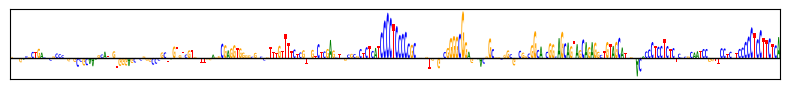

--- Mut ---


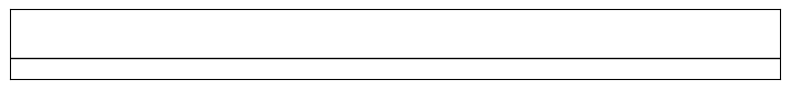

In [39]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_ism_wt,
    np.zeros(pred_ism_wt.shape),
    plot_start=point_start - start - 3 * 128,
    plot_end=point_start - start - 1 * 128,
    save_figs=True,
    fig_name=chrom + '_' + str(start) + '_' + str(end) + '_prediction_ism_shuffle_mut_tss4_5_folds_256bp_wt_only_brain_retry2'
)


In [40]:
#Get contribution scores (ISM Shuffle) for gene coverage; lung

OUTPUT_LENGTH = 16352

dist_bin_start = (70221700 - start - ((SEQUENCE_LENGTH - OUTPUT_LENGTH * 32) // 2)) // 32
dist_bin_end = (70255052 - start - ((SEQUENCE_LENGTH - OUTPUT_LENGTH * 32) // 2)) // 32

[pred_ism_wt] = get_ism_shuffle(
    models,
    [sequence_one_hot_wt],
    point_start - start - 3 * 128,
    point_start - start - 1 * 128,
    0,
    1,
    dist_bin_start,
    dist_bin_end,
    [44, 45, 46],
    0.01,
    3./4.,
    384.,
    window_size=5,
    n_samples=8,
    use_mean=True,
    use_ratio=False,
    use_logodds=False,
)


example_ix = 0
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 

y_min = -0.0931787
y_max = 0.19698326
--- WT ---


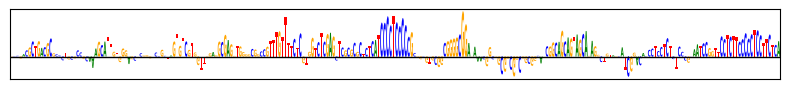

--- Mut ---


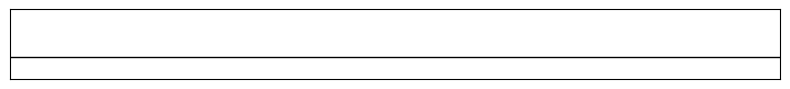

In [41]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_ism_wt,
    np.zeros(pred_ism_wt.shape),
    plot_start=point_start - start - 3 * 128,
    plot_end=point_start - start - 1 * 128,
    save_figs=True,
    fig_name=chrom + '_' + str(start) + '_' + str(end) + '_prediction_ism_shuffle_mut_tss4_5_folds_256bp_wt_only_lung_retry2'
)


In [42]:
#Get contribution scores (ISM Shuffle) for gene coverage; blood

OUTPUT_LENGTH = 16352

dist_bin_start = (70221700 - start - ((SEQUENCE_LENGTH - OUTPUT_LENGTH * 32) // 2)) // 32
dist_bin_end = (70255052 - start - ((SEQUENCE_LENGTH - OUTPUT_LENGTH * 32) // 2)) // 32

[pred_ism_wt] = get_ism_shuffle(
    models,
    [sequence_one_hot_wt],
    point_start - start - 3 * 128,
    point_start - start - 1 * 128,
    0,
    1,
    dist_bin_start,
    dist_bin_end,
    [9, 10, 11],
    0.01,
    3./4.,
    384.,
    window_size=5,
    n_samples=8,
    use_mean=True,
    use_ratio=False,
    use_logodds=False,
)


example_ix = 0
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 89)
predicted_tracks.shape = (1, 4, 16352, 

y_min = -0.17232449
y_max = 0.0889268
--- WT ---


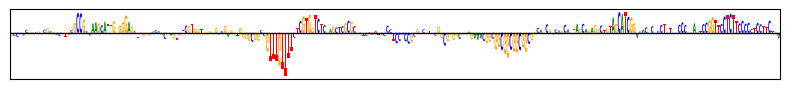

--- Mut ---


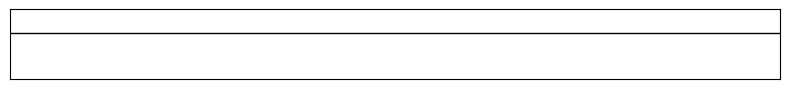

In [43]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_ism_wt,
    np.zeros(pred_ism_wt.shape),
    plot_start=point_start - start - 3 * 128,
    plot_end=point_start - start - 1 * 128,
    save_figs=True,
    fig_name=chrom + '_' + str(start) + '_' + str(end) + '_prediction_ism_shuffle_mut_tss4_5_folds_256bp_wt_only_blood_retry2'
)
